In [1]:
# Obtiene los datos de precipitación par la Cuenca del Valle
# de Méxco a partir de CHIRPS y los promedia espacialmente.

import rioxarray

import pandas as pd
import numpy as np

import geopandas as gpd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import geoviews as gv

In [2]:
path_nc = "../results/CHIRPS_global_days_p05/cuenca_valle_mexico/"
path_shp = "../data/Cuencas/Regiones_Hidrologicas_Administrativas/"
names = ["cuenca_valle_mexico_chirps-v2.0.days_p05.nc", 
    "cuenca_valle_mexico_chirps-v2.0.2021.days_p05.nc",
    "rha250kgw.shp"]

path_r = "../results/onset/"

# Se abre el archivo histórico y el del año en curso.
ds = xr.open_mfdataset(
        [path_nc + x for x in names[0:2]], combine = "nested",
        concat_dim = "time", parallel = True
        )

# Quitamos los 29 de febrero.
ds = ( ds.sel( 
    time=~( (ds.time.dt.month == 2)
    & (ds.time.dt.day == 29) ) ) )

ds

<xarray.Dataset>
Dimensions:    (time: 14812, longitude: 31, latitude: 35)
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2021-07-31
  * longitude  (longitude) float32 -99.73 -99.68 -99.63 ... -98.33 -98.28 -98.23
  * latitude   (latitude) float32 19.07 19.12 19.17 19.22 ... 20.67 20.72 20.77
Data variables:
    precip     (time, latitude, longitude) float32 dask.array<chunksize=(14600, 35, 31), meta=np.ndarray>
Attributes: (12/17)
    CDI:               Climate Data Interface version 1.9.6 (http://mpimet.mp...
    history:           Mon Sep 13 20:14:46 2021: cdo mergetime cuenca_valle_m...
    institution:       Climate Hazards Group.  University of California at Sa...
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    version:           Version 2.0
    ...                ...
    comments:           time variable denotes the first day of the given day.
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ
    CDO:               Climate Data Operators version 1.9.6 (http://mpimet.mp...

In [4]:
# Se carga el contorno de México.
gdf = gpd.read_file(path_shp + names[2])

# Se obtiene el contorno de los países.
gdf["boundary"] = gdf.boundary

# Se establece el datum de los datos.
ds = ds.rio.write_crs(gdf.crs)

# Se hace la máscara de México.
clip = ds.rio.clip(
    gdf[gdf["ORG_CUENCA"] == "Aguas del Valle de México"].geometry,
    gdf.crs, drop=False, invert=False).drop("spatial_ref")

:Overlay
   .Image.I :Image   [longitude,latitude]   (precip)
   .Path.I  :Path   [Longitude,Latitude]   (AREA,PERIMETER,COV_,COV_ID,CLAVE,ORG_CUENCA,CLV_OC,SHAPE_AREA,SHAPE_LEN)
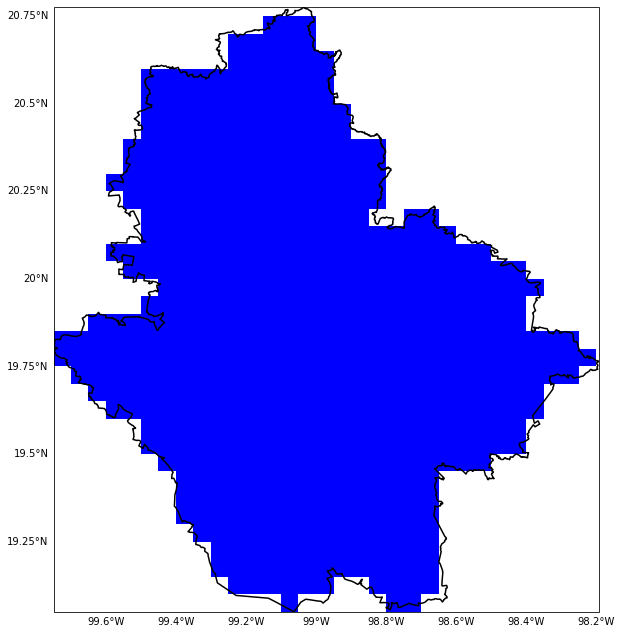

In [6]:
# Se carga el motor gráfico de Geoviews.
gv.extension("matplotlib")
gv.output(size = 300)

kdims = ["longitude", "latitude"]
vdims = ["precip"]

# Se selecciona México.
cuenca = ( gv.Path(
    gdf[gdf["ORG_CUENCA"] == "Aguas del Valle de México"])
    .opts(color = "black") )

clip_1 = xr.ones_like(ds.isel(time = 0) ).rio.clip(
    gdf[gdf["ORG_CUENCA"] == "Aguas del Valle de México"].geometry,
    gdf.crs, drop=False, invert=False).drop("spatial_ref")

#Se gráfica el raster con máscara y el contorno de la Cuenca.
clip_gv = gv.Dataset(clip_1, kdims = kdims, vdims = vdims)
clip_img = clip_gv.to(gv.Image, kdims).opts(cmap = "winter")
grid = clip_img * cuenca

gv.save(grid, path_r + "grid_CHIRPS.png", fmt = "png")

grid

In [8]:
# Precipitación diaria promedio en toda la cuenca.
df = ( clip
    .mean(dim = ["latitude", "longitude"])
    .to_dataframe() )

#df["percentage"] = None

# Cantidad de puntos en la cuenca.
n = ( clip.isel(time = 0)
    .where(clip.isel(time = 0)["precip"] < 0, 1)
    .where(clip.isel(time = 0)["precip"] >= 0, 0)
    .sum(dim = ["latitude"])
    ).to_dataframe()["precip"].sum()

# Porcentaje de puntos con precipitación.
# Media móvil centrada a 15 días.
i = clip.where(clip["precip"] > 0, 0)
df.loc[i["time"].values, "percentage"] = ( i
    .where(i["precip"] <= 0, 1)
    .sum(dim = ["latitude", "longitude"])
    )["precip"].values / n
# Media móvil centrada a 15 días.
df["percentage"] = ( df["percentage"].rolling(
    window = 15, center = True).mean() )

# Media móvil de precipitación centrada a 15 días.
#df[["precip_15", "percentage_15"]] = (
#    df[["precip", "percentage"]]
#    .rolling(window = 15, center = True).mean() )
df["precip"] = ( df["precip"].rolling(
    window = 15, center = True).mean() )
df.columns = ["Cuenca", "percentage"]

# Pentada.
#df[["precip_5", "percentage_5"]] = (
#    df[["precip", "percentage"]]
#    .rolling(window = 5, center = True).mean() )

# Se guardan los datos.
df.to_csv(path_r + "pre_daily_CHIRPS.csv")

print(n)

df

570.0


,Cuenca,percentage
time,,
1981-01-01,NaN,NaN
1981-01-02,NaN,NaN
1981-01-03,NaN,NaN
1981-01-04,NaN,NaN
1981-01-05,NaN,NaN
...,...,...
2021-07-27,NaN,NaN
2021-07-28,NaN,NaN
2021-07-29,NaN,NaN


In [11]:
years = range(1981, 2021)

ds_year = []

for j in years:
    ds_year.append( ds.sel( time = ds.time.dt.year.isin(j) ) )

In [22]:
shift = pd.read_csv(path_r + "shift_CHIRPS.csv",
    index_col = "Año", squeeze = True)

shift

Año
1981    36
1982    41
1983    33
1984    42
1985    40
1986    53
1987    45
1988     7
1989     4
1990    52
1991    44
1992    42
1993     5
1994    44
1995    33
1996    24
1997    41
1998    19
1999     2
2000    29
2001    53
2002    16
2003    24
2004    52
2005     0
2006    53
2007    52
2008    46
2009    40
2010    10
2011     3
2012     5
2013    34
2014    44
2015    44
2016    44
2017    37
2018    53
2019    21
2020    50
Name: Cuenca - Onset, dtype: int64

In [18]:
pre_xr = ds.copy()

# Seleccionamos los años bisiestos.
leap_xr = pre_xr.sel(time = pre_xr.time.dt.is_leap_year)
# Cantidad de años bisiestos.
years_leap = leap_xr.time.shape[0] / 365
# Ponderación para promedio.
leap_xr *= years_leap
# Promedio por día juliano.
leap_xr = leap_xr.groupby("time.dayofyear").mean()
# Corregimos los días de 1 a 365.
leap_xr["dayofyear"] = np.arange(1, 366)
# Dimensión para concatenar.
leap_xr = leap_xr.expand_dims("concat")

# Seleccionamos los años no bisiestos.
not_leap_xr = pre_xr.sel(time = ~pre_xr.time.dt.is_leap_year)
# Cantidad de años bisiestos.
years_not_leap = not_leap_xr.time.shape[0] / 365  
# Ponderación para promedio.
not_leap_xr *= years_not_leap
# Promedio por día juliano.
not_leap_xr = not_leap_xr.groupby("time.dayofyear").mean()
# Dimensión para concatenar.
not_leap_xr = not_leap_xr.expand_dims("concat")

# Promedio ponderado de años bisiestos y no bisiestos.
pre_xr_mean = xr.concat( (not_leap_xr, leap_xr), "concat"
    ).mean("concat") * 2 / (years_leap + years_not_leap)

In [19]:
# Convertimos a DataFrame.
df_mean = pre_xr_mean.drop( "spatial_ref"
    ).mean( ["longitude", "latitude"]
    ).to_dataframe()
df_mean.columns = ["Cuenca"]

# Media móvil.
df_mean = df_mean.iloc[-15:,:].append(
    df_mean.append( df_mean.iloc[0:15,:] ) )
df_mean = df_mean.rolling(15, center = True).mean()
df_mean = df_mean.iloc[15:-15,:]

# Cambiamos de dayofyear a fecha.
df_mean.index = pd.date_range("1995-01-01", 
    "1995-12-31", freq = "1D")

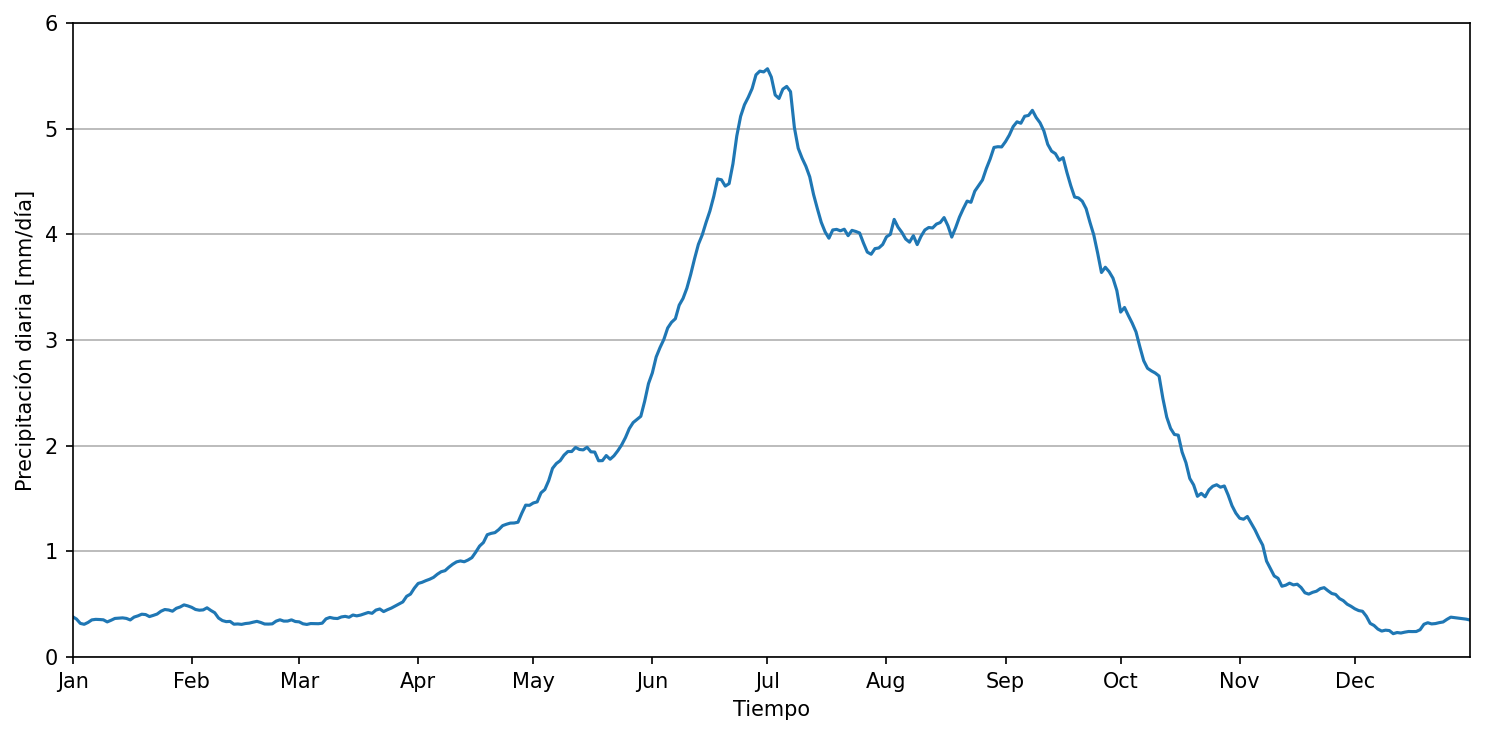

In [20]:
# Graficamos.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(10, 5)
fig.set_dpi(150)

ax.plot(df_mean)
ax.grid(axis = "y")
ax.set_ylabel("Precipitación diaria [mm/día]")
ax.set_xlabel("Tiempo")
ax.set_ylim(0, 6)
ax.set_xlim( pd.to_datetime("1995-01-01"),
    pd.to_datetime("1995-12-31") )
# Formato de fecha.
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))

# Separación adecuada entre gráficas.
fig.tight_layout()

fig.savefig(path_r + "pre_mean_cuenca_CHIRPS.png", bbox_inches = "tight")

In [21]:
# Crea un índice de onset de acuerdo con
# el umbral para n días seguidos de
# cumplimiento con el criterio.
umbral = 2
n = 5

df_mean_ind = pd.DataFrame(
    df_mean.copy(), columns = ["Cuenca"] )

c = "Cuenca"

# Nombre de las columnas dummy.
proc = [c]
for i in range(0, n):
    proc.append(c +
        "_" + str(i)) 

# Traslapa los últimos 3 días 
# y da un valor de 1 a cada día 
# que cumpla con el umbral.
for i, p in enumerate(proc[1:]):
    df_mean_ind[p] = df_mean_ind[proc[0]].shift(i)
    df_mean_ind[p].clip( upper = umbral,
        inplace = True )
    df_mean_ind[p] = df_mean_ind[p].where(
        df_mean_ind[p] == umbral, 0)
    df_mean_ind[p] = df_mean_ind[p].where(
        df_mean_ind[p] < umbral, 1)

# El índice es uno si los n
# cumplen con el umbral.
ind = "Index_" + c
df_mean_ind[ind] = 0
for i in range(n):
    df_mean_ind[ind] += df_mean_ind[proc[i + 1]]
df_mean_ind[ind] = df_mean_ind[ ind
    ].where(df_mean_ind[ind] == n, 0)
df_mean_ind[ind] = df_mean_ind[ ind
    ].where(df_mean_ind[ind] < n, 1)
df_mean_ind[ind] = df_mean_ind[ ind
    ].where( df_mean_ind.index.month.isin(
    range(5, 12) ), 0 )
df_mean_ind.drop(proc[1:],
    axis = 1, inplace = True)

Onset     : 28 May
Withdrawal: 16 October


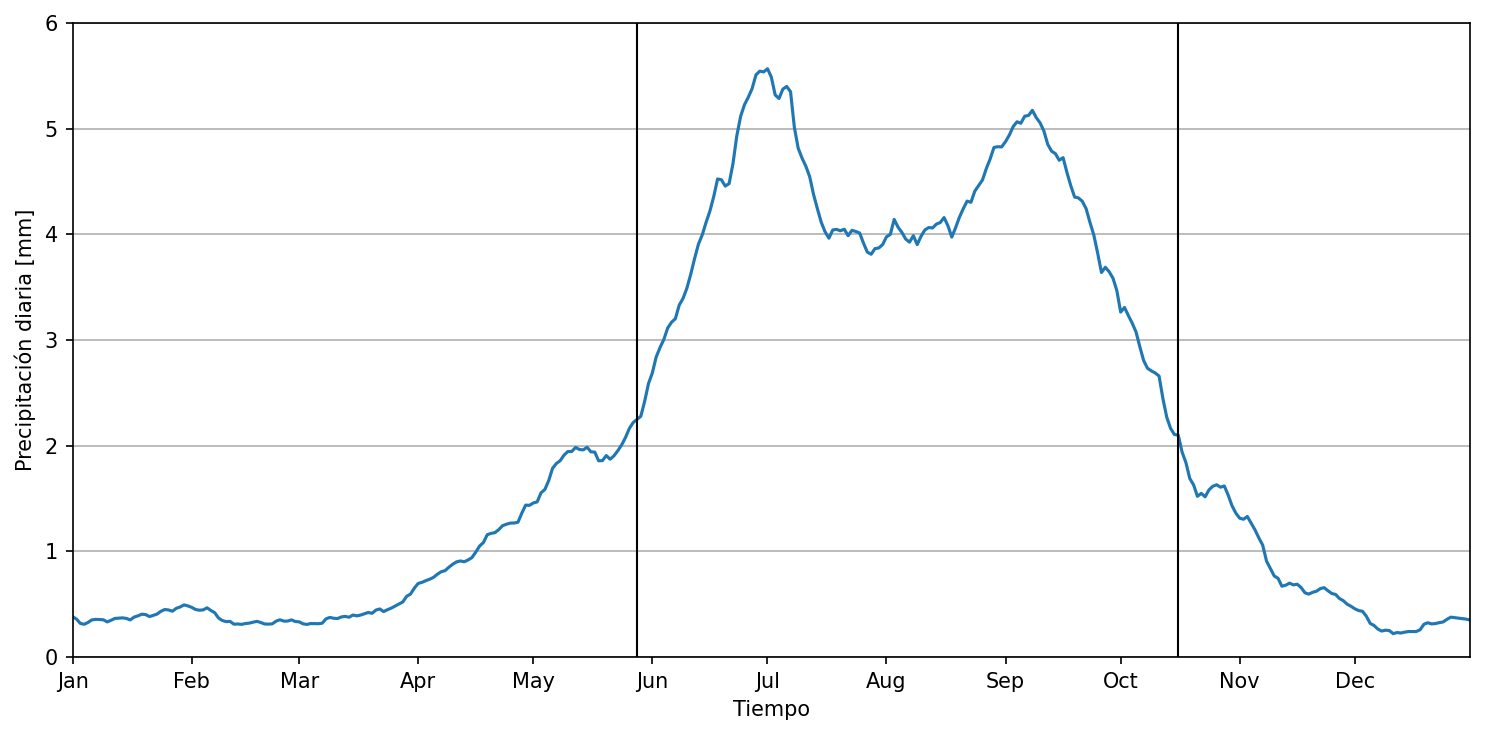

In [22]:
# Fechas.
onset = df_mean_ind.iloc[:, 1].idxmax()
withdrawal = df_mean_ind.iloc[::-1, 1].idxmax()

print(f"Onset     : {onset.day:02d}"
    + f" {onset.month_name()}")
print(f"Withdrawal: {withdrawal.day:02d}"
    + f" {withdrawal.month_name()}")

# Graficamos.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(10, 5)
fig.set_dpi(150)

# Curva suavizada.
ax.plot(df_mean_ind.iloc[:, 0])

# Onset y withdrawal.
ax.plot( (onset, onset), (0, 6),
    color = "k", linewidth = 1 )
ax.plot( (withdrawal, withdrawal), (0, 6),
    color = "k", linewidth = 1 )

ax.set_title(df_mean_ind.iloc[:, 1].name)
ax.grid(axis = "y")
ax.set_ylabel("Precipitación diaria [mm]")
ax.set_xlabel("Tiempo")
ax.set_ylim(0, 6)
ax.set_xlim( pd.to_datetime("1995-01-01"),
    pd.to_datetime("1995-12-31") )
ax.set_title("")
# Formato de fecha.
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))

# Separación adecuada entre gráficas.
fig.tight_layout()

fig.savefig(path_r + "pre_ind_cuenca_CHIRPS.png", bbox_inches = "tight")